# Q-Learning
Model free algorithm used for reinforcement learning. The algorithm will find an optimal policy to maximize the total reward on all of the steps taken starting from the current state. The algorithm uses Q-Value to optimize iteratively the agent.

OpenAI Gym 'CartPole-v1' will be used for the simulation in this notebook. A simple environment to test out the algorithm.

## Warning
**This notebook is made by an amateur in the field of reinforcement learning, so take anything with another check on what you've read here. If you found anything wrong in this notebook please contact the creator.**

Contact:
- [Github](https://www.github.com/fauh45)
- [Twitter](https://www.twitter.com/fauh45)

## Setups
Firstly, we will installing and importing depedencies used in this notebook.

In [1]:
!pip install gym numpy seaborn > /dev/null

In [2]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import math
import itertools
from collections import defaultdict


Then we will make the environment that will be used, that is 'CartPole-v1'.

In [3]:
env = gym.make('CartPole-v1')


## Policy
Policy that will be used are $\epsilon-greedy$. The simple way to explain it is that the policy will choose the best action ($\max Q$)if some $r \geq \epsilon$, or some random choice if $r > \epsilon$, where $r$ is a random number. Or simply
$$(1) \ldots a_{t} = \begin{cases} \max Q & r \geq \epsilon \\ \text{random} & r < \epsilon \end{cases}$$

To get the $\max Q$ from the Q Table, just need to do $\arg \max (Q)$ to get the best probability to do on the current state currently in, as the table has put the best action with the highest probability on that state.

The implementation of the policy itself doesn't really follow the explanation above instead uses a slightly changed system, it follows the algorithm below,

>- Initialize matrix of $P(a)$ (probability of actions taken) with all $1$ with shape $(\text{num_action})$  
>- Calculate $P(a) * \epsilon / \text{num_action}$ as the basis  
>- Search for $\arg \max (Q)$ at the current state from $Q$ to find the best action to be taken  
>- Add $(1 - \epsilon)$ to the matrix $P(a)$ where it represent best action, which is at index $\arg \max (Q)$  
>- Get $\text{random choice} (0, \ldots, \text{num_action})$ where the choice is based on probability $P(a)$  

In [4]:
def getEpsilonGreedyPolicy(Q_table, epsilon, num_action):
    """
        Return an epsilon-greedy policy,
        which will return the action that is between
        0 to (num_action - 1) according to the policy
    """
    def epsilonGreedyPolicy(state):
        # Generate matrix full of one with shape (num_action)
        # Calculate the basis probability
        action_probability = np.ones(num_action, dtype=float) * (epsilon / num_action)
        
        # Search for the best action by searching for the highest probility
        best_action = np.argmax(Q_table[state])
        # Normalized the best action probability
        action_probability[best_action] += (1.0 - epsilon)

        # Get the random choice using probability calculated before
        action = np.random.choice(np.arange(num_action), p=action_probability)
        
        return action
    
    return epsilonGreedyPolicy

## Discreetization
Because of the state produced by the environment will be in float, the possible state of the agent would probably be unlimited. Such that the values needed to be discreetize into some kind of discreete system.

First of all let's look at the sample state produced by the environment.

In [5]:
env.reset()

array([-0.02660507,  0.03015417,  0.0272227 , -0.01796073])

In [6]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [7]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

The result itself are an tuple of 4 float describing the current state of the environment. The problem is with the lower limit, the observation made can be a negative value. While still can technically works, having only positive value would probably make the state space even smaller.

For now the technique used will probably be a naive one, the process will just round up the number to the closest to a number multiply of 0.5, so basically the number in the tuple $O$ is defined by $O \in V$ where $V = \begin{Bmatrix} v | (v \mod 0.5 = 0) \end{Bmatrix}$

In [8]:
def discreetization(state):
    """
        Make continuous state into discreet
        Returns a tuple containing state with
            numbers rounded up to the nearest 0.5
    """
    # Initialized empty list
    discreetedNumber = []

    # For each state tuple value
    # Round up to the closest 0.5
    for obs in state:
        discreetedNumber.append(round(round(obs / 0.5) * 0.5, -int(math.floor(math.log10(0.5)))))

    # Return a tuple
    return tuple(discreetedNumber)

And another discreetization function that normalized the state using the highest and lowest point of each tuple component, and round it up to the nearest integer.

Following [this code](https://github.com/JoeSnow7/Reinforcement-Learning/blob/master/Cartpole%20Q-learning.ipynb).

In [9]:
def integer_discreetizaton(state):
    """
        Make integer tuple of state
        Returns Normalized and rounded up state
    """
    buckets = (3, 3, 6, 6)
    # Initialized empty list
    discreetedNumber = []

    # For each state tuple value
    for i in range(len(state)):
        scaling = ((state[i] + abs(env.observation_space.low[i])) / (env.observation_space.high[i] - env.observation_space.low[i]))

        bucket = buckets[i] - 1
        obs = int(round(bucket * scaling))
        obs = min(bucket, max(0, obs))

        discreetedNumber.append(obs)

    return tuple(discreetedNumber)


## The Algorithm
Then here we will be implementing the algorithm itself. How the algorithm work itself is by finding an optimal policy to maximize reward on all of the steps taken, as was said before.

Reinforment learning have an agent, $s$ as a state of state, and $a$ as the action taken. Then there's the the algorithm—as the agent itself—the weight used for taking an action by the algorithm for the next $\Delta t$ are calculated by $\gamma ^ {\Delta t}$ where $0 \leq \gamma \leq 1$, and $\gamma$ itself as the discount factor or the probability of succeding in the next $\Delta t$.

As also Q-Learning is using a so called Q Table, the way to update it are using the equation below
$$(2) \ldots Q^{new}(s_{t}, a_{t}) \leftarrow \underbrace{Q(s_{t}, a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} . (\overbrace{\underbrace{\underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} . \underbrace{\underset{a}{\max}Q(s_{t + 1}, a)}_{\text{estimate optimal future value}}}_{\text{new value (temporal difference target)}} - \underbrace{Q(s_{t}, a_{t})}_{\text{old value}}}^{\text{temporal difference}})$$

As for the implementation of the algorithm itself, the pseudocode of the algorithm will be shown below,  

>- Initalized $Q(s, a)$ with arbitary values  
>- Repeat (for each episode):  
>>- Initalize $s$  
>>- Repeat (for each step in episode):  
>>>- Choose $a$ from $s$ using policy derived from $Q$ e.g $(\epsilon -greedy)$  
>>>- Take action $a$ observe $r$ and $s'$  
>>>- Update Q-Table using said equation (equation $(2)$)  
>>>- $s \leftarrow s'$  
>>- Until $s$ terminal  

In [10]:
def QLearning(env, num_episodes, discreetization=discreetization ,discount_factor=1.0,
    min_lr=0.1, min_epsilon=0.1, decay=25, render=False):
    """
        Q-Learning Algorithm
        Returns Q Table and statistics of episode length, and cummulative reward
    """
    # Initialization of Q(s, a), where Q[state][action]
    # Creates an dict function where the state default is zero
    Q_table = defaultdict(lambda: np.zeros(env.action_space.n))

    # Initialize stats
    length_stats = []
    reward_stats = []

    # Repeat for each episode
    for i_episode in range(num_episodes):
        # Initialize s
        state = discreetization(env.reset())

        # Initialize stats for current episode
        length_stats.append(0)
        reward_stats.append(0)

        # Calculate decay on the learning rate and epsilon
        learning_rate = max(min_lr, min(1., 1. - math.log10((i_episode + 1) / decay)))
        epsilon = max(min_epsilon, min(1., 1. - math.log10((i_episode + 1) / decay)))

        # Create an policy to be used, epsilon-greedy
        policy = getEpsilonGreedyPolicy(Q_table, epsilon, env.action_space.n)

        # Repeat for each step in episode
        for t in itertools.count():
            # Choose a from s using policy
            action = policy(state)

            # Take action a and observe r and s'
            next_state, reward, done, _ = env.step(action)

            # Make state discreet
            next_state = discreetization(next_state)

            if render:
                env.render()

            # Update stats
            reward_stats[i_episode] += reward

            # Update the Q Table using equation (2)
            # Estimate optimal future value by argmax
            estimate_optimal_future_value = np.argmax(Q_table[next_state])

            # Calculate temporal difference
            temporal_difference = reward + discount_factor *\
                (estimate_optimal_future_value) - Q_table[state][action]
            
            # Update old values
            Q_table[state][action] += learning_rate * temporal_difference

            # Terminal state
            if done:
                length_stats[i_episode] = t
                break

            # Set new state as old state
            state = next_state

    env.close()
    return Q_table, length_stats, reward_stats

## Testing
Using the created env tried out the environment and look at the stats of the run.

In [11]:
# Run the algorithm
Q_table, length, reward = QLearning(env, 1000, discreetization=discreetization, render=True)

Graph out the resulting run of training.

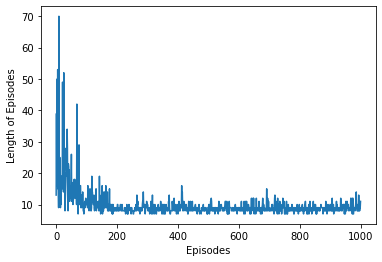

In [12]:
sns.lineplot(range(len(length)), length)
plt.xlabel('Episodes')
plt.ylabel('Length of Episodes')
plt.show()

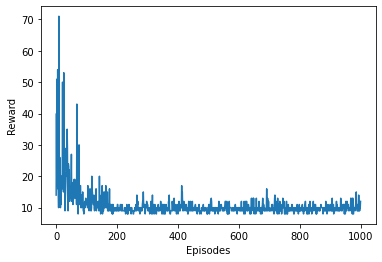

In [13]:
sns.lineplot(range(len(reward)), reward)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

The resulting rewards seems still pretty low and sporadic even after 1000 episode of training, this could be the result of discreetization of the state itself (curse of dimentionality). Also, as Q-Learning is normally only used in a discreet environment, this 'CartPole-v1' environment are continous.

## Future Improvements
Future improvements on this particular algorithm could be by using a double Q-Learning or even moving over to DQN which is way more better at handling this kind of environment.